<a href="https://colab.research.google.com/github/Kammarianand/Text-Classification-/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid',font_scale=1.2)
sns.set_palette(sns.color_palette("rocket"))

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from collections import defaultdict

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Let's start by defining some key variables that will be used later on in the training/evaluation process
RANDOM_SEED = 50
BATCH_SIZE = 16 # Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.
# Set seed for reproducibility.
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
df_reviews = pd.read_csv("bert_sentiment.csv")
df_reviews.head(3)

In [ ]:
# drop review id
df_reviews.drop('reviewId',axis=1,inplace=True)

In [ ]:
# lets check the shape of reviews dataframe
df_reviews.shape

In [ ]:
df_reviews.isnull().sum()


In [ ]:
def draw_percentage(ax,total=float(len(df_reviews))):
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2.
        y = p.get_height()
        ax.annotate(percentage, (x, y),ha='center',va='bottom')

In [ ]:
plt.figure(figsize = (10,6))
total = float(len(df_reviews))
ax = sns.countplot(x = 'score',data=df_reviews)
plt.title('Count Plot of Review Score', fontsize=20)
plt.xlabel('review score')
draw_percentage(ax)
plt.show()

In [ ]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

df_reviews['sentiment'] = df_reviews.score.apply(to_sentiment)

In [ ]:
plt.figure(figsize = (8,6))
total = float(len(df_reviews))
ax = sns.countplot(x = 'sentiment',data=df_reviews)


class_names = ['negative', 'neutral', 'positive']
ax.set_xticklabels(class_names)
plt.title('Count Plot of Review Score', fontsize=20)
plt.xlabel('review sentiment')
draw_percentage(ax)

plt.show()

In [ ]:
# We can use a cased and uncased version of BERT and tokenizer. I am using cased version.
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

# Let's load a pre-trained BertTokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = "we love you"

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

In [ ]:
encoding = tokenizer.encode_plus(
    sample_txt,
    padding='max_length', # Pad sentence to max length
    truncation=True,  #Truncate sentence to max length
    max_length=32,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    return_attention_mask=True, # Return attention mask
    return_tensors='pt',  # Return torch objects
    )

encoding.keys()

In [ ]:
print(len(encoding['input_ids'][0]))
print(encoding['input_ids'][0])

In [ ]:
# The attention mask has the same length
print(len(encoding['attention_mask'][0]))
print(encoding['attention_mask'])

In [ ]:
# We can inverse the tokenization to have a look at the special tokens
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

In [ ]:
# BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length.
# Let's store the token length of each review..

token_lens = []
for text in df_reviews.content:
    tokens = tokenizer.encode(text, truncation=True,max_length=512)
    token_lens.append(len(tokens))

In [ ]:
plt.figure(figsize = (8,6))
sns.histplot(token_lens,kde=True)
plt.xlim([0, 150])
plt.xlabel('Token count')
plt.show()

In [ ]:
MAX_LEN = 150

In [ ]:
# We have all building blocks required to create a torch dataset. Let's do it...
class dataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):

        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        # step 1: get the reviews and targets
        review = str(self.reviews[item])
        target = self.targets[item]
        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True, # Add '[CLS]' and '[SEP]'
            padding='max_length',  # Pad sentence to max length
            truncation=True,    # Truncate sentence to max length
            max_length=self.max_len,
            return_token_type_ids=False,
            return_attention_mask=True, # Return attention mask
            return_tensors='pt', # return torch objects/tensor
        )
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),  # Tensor of token ids to be fed to a model
            'attention_mask': encoding['attention_mask'].flatten(),  #Tensor of indices specifying which tokens should be attended to by the model
            'targets': torch.tensor(target, dtype=torch.long)
            }

In [ ]:
df_train, df_test = train_test_split(df_reviews, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print('Train Data Size', df_train.shape)
print('Validation Data Size', df_val.shape)
print('Test Data Size', df_test.shape)


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = dataset(
        reviews=df.content.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )
    return DataLoader(
        ds,
        batch_size=batch_size
      )


In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)


In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)
# The last_hidden_state is a sequence of hidden states of the last layer of the model.
# Obtaining the pooled_output is done by applying the BertPooler on last_hidden_state.
last_hidden_state.shape

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)
        # dropout layer for some regularization
        self.drop = nn.Dropout(p=0.3)
        # A fully-connected layer for our output
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        last_hidden_state,pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)


In [ ]:
# Let's create an instance and move it to the GPU.
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
# We'll move the example batch of our training data to the GPU
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

In [ ]:
EPOCHS = 3
#  AdamW optimizer to correct weight decay
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
#  We'll also use a linear scheduler with no warmup steps
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
# cross-entropy loss function
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    # put model in training mode
    model = model.train()
    # Create empty lists to store outputs
    losses = []
    correct_predictions = 0
    for batch in data_loader:
        # We'll move the example batch of our training data to the GPU
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        targets = batch["targets"].to(device)

        # Perform a forward pass. This will return logits.
        outputs = model(
              input_ids=input_ids,
              attention_mask=attention_mask
            )
        # Get the predictions
        _, preds = torch.max(outputs, dim=1)

        # Compute loss and accumulate the loss values
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # Calculate the accuracy rate
        correct_predictions += torch.sum(preds == targets)
        # backward pass - Perform a backward pass to calculate gradients
        loss.backward()
        # gradient clipping - Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # Update parameters and the learning rate
        optimizer.step()
        scheduler.step()
        # Zero out any previously calculated gradients
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    # put model in evaluation mode
    model = model.eval()
    # Create empty lists to store outputs
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for batch in data_loader:
            # We'll move the example batch of our validation data to the GPU
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["targets"].to(device)

            # Perform a forward pass. This will return logits.
            outputs = model(input_ids=input_ids,attention_mask=attention_mask)
            # Get the predictions
            _, preds = torch.max(outputs, dim=1)

            # Compute loss and accumulate the loss values
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())
            # Calculate the accuracy rate
            correct_predictions += torch.sum(preds == targets)

    return correct_predictions.double() / n_examples, np.mean(losses)

In [84]:
%%time
history = defaultdict(list)
best_accuracy = 0
# Start training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 100)
    # model training
    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss} accuracy {train_acc}')
    # After the completion of each training epoch, measure the model's performance on our validation set.
    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
    print(f'Val loss   {val_loss} accuracy {val_acc}')
    print()
    # append training accuracy,loss and validation accuracy and loss to the history variable
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model based on below condition
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/3
----------------------------------------------------------------------------------------------------
Train loss 0.7267277821750084 accuracy 0.7149844375277902
Val loss   0.5925249550491571 accuracy 0.768

Epoch 2/3
----------------------------------------------------------------------------------------------------
Train loss 0.5526531138384495 accuracy 0.7848821698532682
Val loss   0.5813335690647363 accuracy 0.7712

Epoch 3/3
----------------------------------------------------------------------------------------------------
Train loss 0.446116003900724 accuracy 0.8315695864828813
Val loss   0.6558079111855477 accuracy 0.7536

CPU times: user 10min 26s, sys: 4min 22s, total: 14min 49s
Wall time: 15min 29s


In [85]:
history_cpu_train_acc = [i.cpu() for i in history['train_acc']]
history_cpu_val_acc = [i.cpu() for i in history['val_acc']]

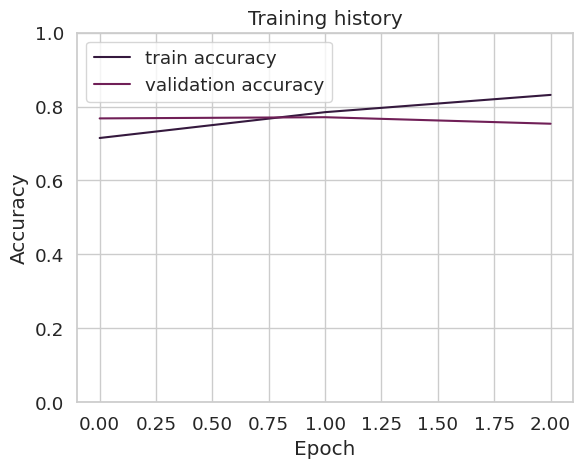

In [86]:
plt.plot(history_cpu_train_acc, label='train accuracy')
plt.plot(history_cpu_val_acc, label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()

In [87]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

In [88]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.7664000000000001

In [89]:
def get_predictions(model, data_loader):
  # put model in evaluation mode
  model = model.eval()
  # Create empty lists to store outputs
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for batch in data_loader:
      # We'll move the example batch of our test data to the GPU
      texts = batch["review_text"]
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      targets = batch["targets"].to(device)
      # Perform a forward pass. This will return logits.
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      # Get the predictions
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [90]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)


In [91]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.81      0.76      0.79       238
     neutral       0.37      0.24      0.29        94
    positive       0.81      0.94      0.87       293

    accuracy                           0.77       625
   macro avg       0.66      0.65      0.65       625
weighted avg       0.74      0.77      0.75       625



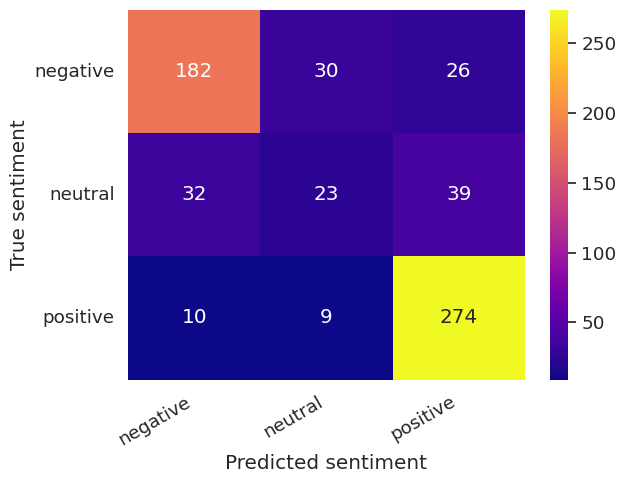

In [92]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="plasma")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [93]:
idx = 50
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

from textwrap import wrap
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

A fantastic and helpful app became useless with the last update.
Grouping open and completed tasks may be helpful for some, but for
some types of lists it would be really handy to have all tasks
together. For example a picking list (or shopping list) with the items
sorted in order of their position in the warehouse. You do not need
everything every time, so you can just uncheck the items when needed
during a round, possibly hiding the completed tasks to minimize screen
cluttering. This was possible before, but with the recent update(s)
all completed tasks have moved to a separate list. All custom sorting
is lost. Dear Microsoft, please re enable these features. You could
provide an option in settings to use one or the other. (Maybe even on
a list level) 2 stars because it used to be a good app, otherwise I
would have now given it only 1 star.

True sentiment: negative


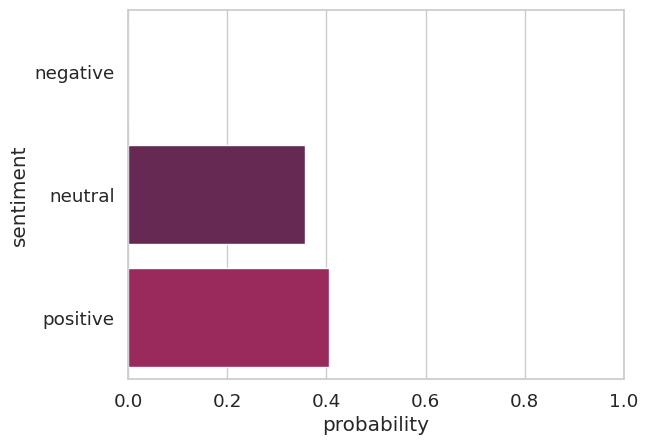

In [94]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1])
plt.show()

In [95]:
# Let's use our model to predict the sentiment of some raw text
raw_text = "It is very useful for seening plans for recharging jio. We can recharge plans easily by using this my jio app."


In [96]:
def prediction_on_raw_data(raw_text):
  encoded_review = tokenizer.encode_plus(
  raw_text,
  padding='max_length', # Pad sentence to max length
  truncation=True,  #Truncate sentence to max length
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  return_attention_mask=True, # Return attention mask
  return_tensors='pt',  # Return torch objects
  )

  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)
  output = model(input_ids, attention_mask)

  _, prediction = torch.max(output, dim=1)

  print(f'Review text: {raw_text}')
  print(f'Sentiment  : {class_names[prediction]}')

In [97]:
prediction_on_raw_data(raw_text)

Review text: It is very useful for seening plans for recharging jio. We can recharge plans easily by using this my jio app.
Sentiment  : positive


In [98]:
raw_text = "this app is not that good"
prediction_on_raw_data(raw_text)


Review text: this app is not that good
Sentiment  : negative


In [99]:
imdb_google_review = "Logan (2017) delivers a gritty and emotional portrayal of Wolverine's journey, offering a bittersweet farewell to the beloved character. Hugh Jackman's performance shines, evoking a mix of nostalgia and poignancy. The film's somber tone and intense action sequences contribute to its impact, though some might find its darkness a bit overwhelming"
prediction_on_raw_data(imdb_google_review)


Review text: Logan (2017) delivers a gritty and emotional portrayal of Wolverine's journey, offering a bittersweet farewell to the beloved character. Hugh Jackman's performance shines, evoking a mix of nostalgia and poignancy. The film's somber tone and intense action sequences contribute to its impact, though some might find its darkness a bit overwhelming
Sentiment  : positive


<h1>Movie Review Analysis</h1>

In [100]:
import pandas as pd
imdb_reviews = [
    {"movie": "Interstellar", "review": "A science-fiction masterpiece. Nolan executes a marvelous direction that slowly but efficiently puts in place a dark world creating a necessity to save humanity. Add to that great performances from Nolan and Hathaway plus a great score from Hans Zimmer. The result is on the best science-fiction movies of all time"},
    {"movie": "Oppenheimer", "review": "I'm a big Nolan fan. Maybe this one just wasn't for me.This movie was promoted as the story of the invention of the bomb. We were told we should see it on the biggest screen. Go out of your way for an IMAX 70mm projection if you can, or at least get a regular 70mm or Laser IMAX."},
    {"movie": "Jailer", "review": "Nelson, you've truly exceeded expectations with your latest film, Jailer! This movie takes a fresh approach to the thriller genre, blending it seamlessly with your characteristic humor that will leave the audience in stitches. It's an exhilarating dark comedy rollercoaster that keeps you hooked throughout."},
    {"movie": "Gadar 2", "review": "Undoubtedly Sunny Deol was very nice but I found the movie very annoying and specially the acting of the actress Ameesha Patel the new actress and the son. They definitely try to make some scenes emotional but they fail to do so and I really hate the writing of the writers. I mean this movie is coming after decades and a movie for only like stupid people, Pakistan was shown like North Korea"},

]


for review_data in imdb_reviews:
    review = review_data["review"]
    movie = review_data["movie"]
    print(f"Movie: {movie}")
    sentiment = prediction_on_raw_data(review)

    print("")

Movie: Interstellar
Review text: A science-fiction masterpiece. Nolan executes a marvelous direction that slowly but efficiently puts in place a dark world creating a necessity to save humanity. Add to that great performances from Nolan and Hathaway plus a great score from Hans Zimmer. The result is on the best science-fiction movies of all time
Sentiment  : positive

Movie: Oppenheimer
Review text: I'm a big Nolan fan. Maybe this one just wasn't for me.This movie was promoted as the story of the invention of the bomb. We were told we should see it on the biggest screen. Go out of your way for an IMAX 70mm projection if you can, or at least get a regular 70mm or Laser IMAX.
Sentiment  : positive

Movie: Jailer
Review text: Nelson, you've truly exceeded expectations with your latest film, Jailer! This movie takes a fresh approach to the thriller genre, blending it seamlessly with your characteristic humor that will leave the audience in stitches. It's an exhilarating dark comedy rollerc

In [101]:
#positive review


hello world


In [105]:
positive_texts = [
    "I absolutely loved the movie, it was captivating from start to finish!",
    "The weather is fantastic today, perfect for a picnic in the park.",
    "The new restaurant in town has amazing food and excellent service."
]


In [106]:
for text in positive_texts:
    print(prediction_on_raw_data(text))

Review text: I absolutely loved the movie, it was captivating from start to finish!
Sentiment  : positive
None
Review text: The weather is fantastic today, perfect for a picnic in the park.
Sentiment  : positive
None
Review text: The new restaurant in town has amazing food and excellent service.
Sentiment  : positive
None


In [107]:
negative_texts = [
    "I had a terrible experience with the customer service, no one was willing to help.",
    "The movie was a huge disappointment, the plot was confusing and the acting was subpar.",
    "The traffic this morning was unbearable, it took me twice as long to get to work."
]

In [108]:
for text in negative_texts:
    print(prediction_on_raw_data(text))

Review text: I had a terrible experience with the customer service, no one was willing to help.
Sentiment  : negative
None
Review text: The movie was a huge disappointment, the plot was confusing and the acting was subpar.
Sentiment  : negative
None
Review text: The traffic this morning was unbearable, it took me twice as long to get to work.
Sentiment  : negative
None


In [109]:
neutral_texts = [
    "The report contains a comprehensive analysis of the market trends.",
    "The conference will take place at the convention center from 9 AM to 5 PM.",
    "The new software update includes several bug fixes and performance improvements."
]

In [110]:
for text in neutral_texts:
    print(prediction_on_raw_data(text))

Review text: The report contains a comprehensive analysis of the market trends.
Sentiment  : positive
None
Review text: The conference will take place at the convention center from 9 AM to 5 PM.
Sentiment  : negative
None
Review text: The new software update includes several bug fixes and performance improvements.
Sentiment  : positive
None
